In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence
from sqlalchemy import or_

In [3]:
from snorkel.lf_helpers import *
import pickle

/home/antonis/anaconda2/envs/python27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
from sqlalchemy import  or_, and_,any_

In [5]:
with open('../candidates_TrainValTestOutgoing.pickle', 'rb') as f:
    cands = pickle.load(f)

In [9]:
from snorkel.models import Candidate, candidate_subclass
REGULATOR = candidate_subclass('REGULATOR', ['Chemical', 'Gene'])

# ~

In [7]:
# LF to load gold labels
def return_gold_labels(c):
    try:
        return cands[0][c.id]['label']
    except KeyError:
        try:
            return cands[1][c.id]['label']
        except KeyError:
            try:
                return cands[2][c.id]['label']
            except KeyError:
                return 0

In [8]:
# LF to load gold labels
def return_gold_labels2(c):
    
    try:
        return cands[0][c.id]['label']
    except KeyError:
        try:
            return cands[1][c.id]['label']
        except KeyError:
            try:
                return cands[2][c.id]['label']
            except KeyError:
                return 0

In [10]:
LFs = [
    return_gold_labels,
    return_gold_labels2
]

# Drop the unmapped labels

In [11]:
for k in range (3):
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, REGULATOR.gold_labels.any())).count()
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, ~REGULATOR.gold_labels.any())).count()

12968
0
3237
0
8278
0


In [12]:
# #get all ids to drop (in train-dev & without labels)
# todrop = list(map(lambda x: x.id ,session.query(REGULATOR).filter(and_(REGULATOR.split.in_([0,1]), ~REGULATOR.labels.any())).all()))
# print 'Will drop %i candidates'%len(todrop)

In [13]:
# session.query(REGULATOR).filter(REGULATOR.id.in_(todrop)).delete(synchronize_session=False)
# session.commit()

In [14]:
# #check if deleted
# session.query(REGULATOR).filter(~(REGULATOR.labels.any())).count()

** Handle Candidate labels? **

In [15]:
# #check if deleted
# session.query(Candidate).filter(~(Candidate.labels.any())).count()

In [16]:
# session.query(Candidate).filter(Candidate.id.in_(todrop)).delete(synchronize_session=False)
# session.commit()

In [17]:
# #check if deleted
# session.query(Candidate).filter(~(Candidate.labels.any())).count()

# Train the generative model (denoise)

In [12]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [13]:
# combined train+dev marginals from previous step (saved in the same split number dureing preprocessing)

In [14]:
# save train. set marginals
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 14.5 s, sys: 12 ms, total: 14.6 s
Wall time: 14.6 s


<12968x2 sparse matrix of type '<type 'numpy.int64'>'
	with 25936 stored elements in Compressed Sparse Row format>

In [15]:
# see how many LF vote on how many examples & with how many other LFs there are votes on common examples
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
return_gold_labels,0,1.0,1.0,0.0
return_gold_labels2,1,1.0,1.0,0.0


In [16]:
# actual training of the gen. model
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=False)
gen_model.train(
    L_train, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0 , #deps=deps,
)

Inferred cardinality: 2


In [17]:
train_marginals = gen_model.marginals(L_train)

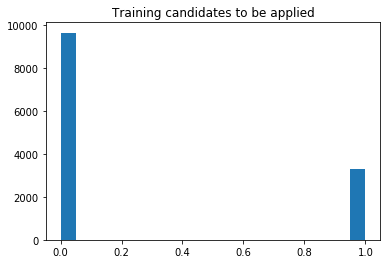

In [18]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.title('Training candidates to be applied')
plt.show()

In [19]:
# save probabilistic labels for the LSTM  -  this is the # of train. examples our LSTM will train on
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 12968 marginals


## Load & balance dataset

In [6]:
from snorkel.annotations import load_gold_labels,load_marginals

In [10]:
from snorkel.annotations import load_marginals

train_cands  = session.query(REGULATOR).filter(REGULATOR.split == 0).all()
val_cands  = session.query(REGULATOR).filter(REGULATOR.split == 1).all()
test_cands  = session.query(REGULATOR).filter(REGULATOR.split == 2).all()
unlab_cands = session.query(REGULATOR).filter(REGULATOR.split == 3).all()

train_marginals = load_marginals(session, split=0)
# val_marginals = load_marginals(session, split=1)
# test_marginals = load_marginals(session, split=2)
# unlab_marginals = load_marginals(session, split=3)

# L_gold_train = load_gold_labels(session, annotator_name='gold', split=0, load_as_array=True, zero_one=True)
L_gold_val  = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True, zero_one=True)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, load_as_array=True, zero_one=True)

In [11]:
train_marginals

array([9.99336732e-01, 6.63268231e-04, 9.99336732e-01, ...,
       6.63268231e-04, 6.63268231e-04, 9.99336732e-01])

In [12]:
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd


def balance_candidates(cands, marginals, rs = 42):
    """Balance and shuffle candidates along with their (prob) labels.
    
    cands: list of candidate objects
    marginals: list of marginal (or not) labels
    rs: int: random_state (used in RandomUnderSampler and sklearn.utils.shuffle) 
    """
    rus = RandomUnderSampler(random_state=rs,return_indices=True)
    marginals_01 = np.round(marginals)

    _,_, indices = rus.fit_sample(pd.DataFrame(marginals), np.round(marginals))

    # shuffle indices
    indices = shuffle(indices, random_state = rs)

    # keep only selected items
    cands_us = [cands[i] for i in indices]
    marginals_us = [marginals[i] for i in indices]
    
    return cands_us, np.array(marginals_us)

In [13]:
train_cands_us, train_marginals_us = balance_candidates(train_cands,train_marginals)

# LSTM training

In [14]:
from snorkel.learning import GridSearch
from snorkel.learning import reRNN

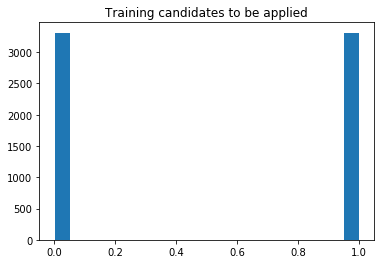

In [15]:
import matplotlib.pyplot as plt
plt.hist(train_marginals_us, bins=20)
plt.title('Training candidates to be applied')
plt.show()

In [ ]:

#    dropout  batch_size  n_epochs     lr  max_sentence_length  rebalance  \
# 2     0.25          32        20  0.001                  128       0.25   
# 8     0.25          32         5  0.001                   64       0.25

In [16]:
train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   8,
    'dropout':    0.25,
    'rebalance':  0.25,
    'print_freq': 1,
    'batch_size': 32,
    'max_sentence_length': 64,
}

lstm = reRNN(seed=1701, n_threads=None,)
lstm.train(train_cands_us, train_marginals_us, X_dev = val_cands , Y_dev = L_gold_val, **train_kwargs)

/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 20 has argument past max length for model:	[arg ends at index 72; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 48 has argument past max length for model:	[arg ends at index 113; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 87 has argument past max length for model:	[arg ends at index 70; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 97 has argument past max length for model:	[arg ends at index 78; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 168 has argument past max

/home/antonis/anaconda2/envs/python27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4415  #epochs=8  batch size=32
[reRNN] Epoch 0 (11.47s)	Average loss=0.514016	Dev F1=18.20
[reRNN] Epoch 1 (25.28s)	Average loss=0.350534	Dev F1=30.33
[reRNN] Epoch 2 (38.95s)	Average loss=0.272211	Dev F1=43.74
[reRNN] Epoch 3 (52.62s)	Average loss=0.225053	Dev F1=47.55
[reRNN] Epoch 4 (66.28s)	Average loss=0.187585	Dev F1=37.37
[reRNN] Epoch 5 (79.91s)	Average loss=0.162263	Dev F1=42.64
[reRNN] Epoch 6 (93.58s)	Average loss=0.151395	Dev F1=44.93
[reRNN] Epoch 7 (107.18s)	Average loss=0.131319	Dev F1=49.57
[reRNN] Model saved as <reRNN>
[reRNN] Training done (110.11s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-7
[reRNN] Loaded model <reRNN>


In [17]:
pd.Series(L_gold_val).value_counts()

0    2532
1     705
dtype: int64

In [18]:
pd.Series(train_marginals_us).value_counts()

0.999337    3311
0.000663    3311
dtype: int64

# Evaluate on val/test

In [121]:
# def print_pos_prf(tp,fp,tn,fn):
#     prec = (1.0*tp/(tp+fp))
#     rec = (1.0*tp/ (tp+fn))
#     f1 = (2*prec*rec)/float(prec+rec)
#     print "Precision (+):\t %.2f \nRecall (+):\t %.2f \nF1 score (+):\t %.2f \n"%(prec,rec, f1)

In [19]:
tp, fp, tn, fn = lstm.error_analysis(session, val_cands, L_gold_val)

/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 68 has argument past max length for model:	[arg ends at index 65; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 69 has argument past max length for model:	[arg ends at index 65; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 188 has argument past max length for model:	[arg ends at index 69; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 190 has argument past max length for model:	[arg ends at index 69; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 192 has argument past ma

Scores (Un-adjusted)
Pos. class accuracy: 0.489
Neg. class accuracy: 0.865
Precision            0.502
Recall               0.489
F1                   0.496
----------------------------------------
TP: 345 | FP: 342 | TN: 2190 | FN: 360



In [20]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 82 has argument past max length for model:	[arg ends at index 66; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 83 has argument past max length for model:	[arg ends at index 66; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 84 has argument past max length for model:	[arg ends at index 66; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 393 has argument past max length for model:	[arg ends at index 69; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 394 has argument past max

Scores (Un-adjusted)
Pos. class accuracy: 0.42
Neg. class accuracy: 0.884
Precision            0.534
Recall               0.42
F1                   0.47
----------------------------------------
TP: 834 | FP: 728 | TN: 5564 | FN: 1152



## Determine sentence length statistics (for LSTM hidden units)

In [81]:
def get_sentence_length(candidate):
    """Get sentence length of a certain candidate"""
    return len(candidate.get_parent().entity_types)

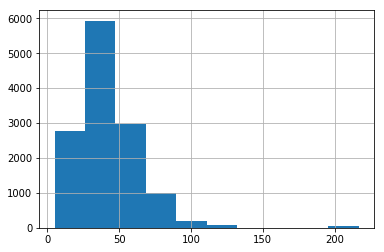

In [82]:
lengths = pd.Series(list(map(lambda x: get_sentence_length(x),train_cands)))
plt.title("Sentence length histogram (words)")

# Grid Search

In [ ]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 1,
    'batch_size': 32,
    'max_sentence_length': 64,
}

In [101]:
from snorkel.learning import RandomSearch, GridSearch
from snorkel.learning import SparseLogisticRegression

seed = 1234
num_model_search = 10

# search over this parameter grid
param_grid = {}
# param_grid['batch_size'] = [32, 64]
# param_grid['lr']         = [1e-3, 1e-2]
# param_grid['dropout'] = [0.25,0.5]
# param_grid['rebalance']  = [0.0, 0.25]

param_grid['max_sentence_length']  = [32, 64, 128]

param_grid['batch_size'] = [32]
param_grid['lr']         = [1e-3]
param_grid['dropout'] = [0.25]
param_grid['rebalance']  = [0.0, 0.25]
param_grid['n_epochs'] = [5,10,20]


model_hyperparams = {
#     'n_epochs': 20,
    'print_freq': 5,
    'dev_ckpt_delay': 0.5,
    'X_dev': val_cands,
    'Y_dev': L_gold_val
}

model_class_params = {
    'seed': seed,
    'n_threads':1
}

# Undersampling
searcher = RandomSearch(reRNN, param_grid, train_cands_us, train_marginals_us,
                        n=num_model_search, seed=seed,
                        model_class_params=model_class_params,
                        model_hyperparams=model_hyperparams)

In [102]:
print "Discriminitive Model Parameter Space (seed={}):".format(seed)
for i, params in enumerate(searcher.search_space()):
    print i, params

disc_model, run_stats = searcher.fit(X_valid=val_cands, Y_valid=L_gold_val, n_threads=1)
print run_stats

Discriminitive Model Parameter Space (seed=1234):
0 (0.25, 32, 20, 0.001, 128, 0.0)
1 (0.25, 32, 10, 0.001, 32, 0.25)
2 (0.25, 32, 5, 0.001, 32, 0.25)
3 (0.25, 32, 5, 0.001, 128, 0.0)
4 (0.25, 32, 5, 0.001, 128, 0.0)
5 (0.25, 32, 10, 0.001, 128, 0.25)
6 (0.25, 32, 10, 0.001, 32, 0.0)
7 (0.25, 32, 10, 0.001, 32, 0.0)
8 (0.25, 32, 20, 0.001, 32, 0.25)
9 (0.25, 32, 20, 0.001, 64, 0.0)
[1] Testing dropout = 2.50e-01, batch_size = 3.20e+01, n_epochs = 1.00e+01, lr = 1.00e-03, max_sentence_length = 1.28e+02, rebalance = 0.00e+00


/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 8343 has argument past max length for model:	[arg ends at index 140; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 8344 has argument past max length for model:	[arg ends at index 140; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 8345 has argument past max length for model:	[arg ends at index 166; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 8346 has argument past max length for model:	[arg ends at index 166; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 8347 has a

[reRNN] Training model
[reRNN] n_train=12968  #epochs=10  batch size=32
[reRNN] Epoch 0 (30.20s)	Average loss=0.474521	Dev F1=48.86
[reRNN] Epoch 5 (182.29s)	Average loss=0.128011	Dev F1=55.23
[reRNN] Epoch 9 (303.78s)	Average loss=0.061333	Dev F1=53.27
[reRNN] Model saved as <reRNN>
[reRNN] Training done (305.92s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-9
[reRNN] Loaded model <reRNN>


/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1860 has argument past max length for model:	[arg ends at index 172; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1861 has argument past max length for model:	[arg ends at index 148; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1862 has argument past max length for model:	[arg ends at index 148; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1863 has argument past max length for model:	[arg ends at index 148; max len 128]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1864 has a

[reRNN] F-1 Score: 0.53267435475
[reRNN] Model saved as <reRNN_0>
[reRNN] Model saved as <reRNN_best>
[2] Testing dropout = 2.50e-01, batch_size = 3.20e+01, n_epochs = 2.00e+01, lr = 1.00e-03, max_sentence_length = 6.40e+01, rebalance = 0.00e+00


/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 197 has argument past max length for model:	[arg ends at index 79; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 198 has argument past max length for model:	[arg ends at index 79; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 199 has argument past max length for model:	[arg ends at index 79; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 200 has argument past max length for model:	[arg ends at index 79; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 201 has argument past 

[reRNN] Training model
[reRNN] n_train=12968  #epochs=20  batch size=32
[reRNN] Epoch 0 (19.44s)	Average loss=0.466830	Dev F1=51.32
[reRNN] Epoch 5 (115.88s)	Average loss=0.126752	Dev F1=53.24
[reRNN] Epoch 10 (211.96s)	Average loss=0.047793	Dev F1=53.94
[reRNN] Epoch 15 (308.11s)	Average loss=0.030552	Dev F1=54.40
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 19 (385.51s)	Average loss=0.017710	Dev F1=53.86
[reRNN] Training done (387.00s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-15
[reRNN] Loaded model <reRNN>


/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 68 has argument past max length for model:	[arg ends at index 65; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 69 has argument past max length for model:	[arg ends at index 65; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 188 has argument past max length for model:	[arg ends at index 69; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 190 has argument past max length for model:	[arg ends at index 69; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 192 has argument past ma

[reRNN] F-1 Score: 0.544
[reRNN] Model saved as <reRNN_1>
[reRNN] Model saved as <reRNN_best>
[3] Testing dropout = 2.50e-01, batch_size = 3.20e+01, n_epochs = 2.00e+01, lr = 1.00e-03, max_sentence_length = 1.28e+02, rebalance = 2.50e-01
[reRNN] Training model
[reRNN] n_train=12876  #epochs=20  batch size=32
[reRNN] Epoch 0 (30.00s)	Average loss=0.456538	Dev F1=51.63
[reRNN] Epoch 5 (179.46s)	Average loss=0.122536	Dev F1=54.66
[reRNN] Epoch 10 (329.26s)	Average loss=0.046233	Dev F1=55.08
[reRNN] Epoch 15 (478.76s)	Average loss=0.027584	Dev F1=52.68
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 19 (599.19s)	Average loss=0.024927	Dev F1=54.78
[reRNN] Model saved as <reRNN>
[reRNN] Training done (601.26s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-19
[reRNN] Loaded model <reRNN>
[reRNN] F-1 Score: 0.547762998791
[reRNN] Model saved as <reRNN_2>
[reRNN] Model saved as <reRNN_best>
[4] Testing dropout = 2.50e-01, batch_size = 3.20e+01, n_epochs = 2.00e+01, lr = 1.00e-0

/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 11 has argument past max length for model:	[arg ends at index 32; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 12 has argument past max length for model:	[arg ends at index 32; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 13 has argument past max length for model:	[arg ends at index 32; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 14 has argument past max length for model:	[arg ends at index 32; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 15 has argument past max l

/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 6550 has argument past max length for model:	[arg ends at index 55; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 6551 has argument past max length for model:	[arg ends at index 49; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 6552 has argument past max length for model:	[arg ends at index 60; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 6553 has argument past max length for model:	[arg ends at index 60; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 6554 has argument 

[reRNN] Training model
[reRNN] n_train=12876  #epochs=20  batch size=32
[reRNN] Epoch 0 (11.94s)	Average loss=0.449000	Dev F1=48.70
[reRNN] Epoch 5 (70.95s)	Average loss=0.136950	Dev F1=51.19
[reRNN] Epoch 10 (130.03s)	Average loss=0.076737	Dev F1=52.82
[reRNN] Epoch 15 (188.99s)	Average loss=0.049531	Dev F1=48.71
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 19 (236.69s)	Average loss=0.040630	Dev F1=49.89
[reRNN] Model saved as <reRNN>
[reRNN] Training done (237.96s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-19
[reRNN] Loaded model <reRNN>


/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 0 has argument past max length for model:	[arg ends at index 33; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 2 has argument past max length for model:	[arg ends at index 54; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 4 has argument past max length for model:	[arg ends at index 33; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 7 has argument past max length for model:	[arg ends at index 39; max len 32]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 9 has argument past max length

[reRNN] F-1 Score: 0.498853211009
[5] Testing dropout = 2.50e-01, batch_size = 3.20e+01, n_epochs = 5.00e+00, lr = 1.00e-03, max_sentence_length = 1.28e+02, rebalance = 2.50e-01
[reRNN] Training model
[reRNN] n_train=12876  #epochs=5  batch size=32
[reRNN] Epoch 0 (30.09s)	Average loss=0.456538	Dev F1=51.63
[reRNN] Epoch 4 (150.02s)	Average loss=0.152741	Dev F1=52.18
[reRNN] Model saved as <reRNN>
[reRNN] Training done (152.13s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-4
[reRNN] Loaded model <reRNN>
[reRNN] F-1 Score: 0.521836506159
[6] Testing dropout = 2.50e-01, batch_size = 3.20e+01, n_epochs = 1.00e+01, lr = 1.00e-03, max_sentence_length = 1.28e+02, rebalance = 2.50e-01
[reRNN] Training model
[reRNN] n_train=12876  #epochs=10  batch size=32
[reRNN] Epoch 0 (29.93s)	Average loss=0.456538	Dev F1=51.63
[reRNN] Epoch 5 (178.98s)	Average loss=0.122536	Dev F1=54.66
[reRNN] Epoch 9 (298.83s)	Average loss=0.050516	Dev F1=54.41
[reRNN] Model saved as <reRNN>
[reRNN]

# Predict on val & unlab 

In [27]:
import pickle

In [28]:
with open('../candidates_TrainValTestOutgoing.pickle', 'rb') as f:
    cand_dict = pickle.load(f)

In [40]:
# from snorkel.learning import reRNN

# lstm = reRNN(seed=1701, n_threads=None,)

In [ ]:
# # lstm.load(model_name='reRNN_14',save_dir="checkpoints/grid_search/")
# disc_model=lstm

## export results

In [33]:
from sklearn.metrics import classification_report, f1_score

In [30]:
results_dict = {}

In [ ]:
# classification_report()

In [ ]:
# # val_ground_truth = dict(map(lambda x: (x, cand_dict[1][x]['label']), cand_dict[1].keys()))
# val_ground_truth = list(map(lambda x: cand_dict[1][x]['label'], cand_dict[1].keys()))
# test_ground_truth = list(map(lambda x: cand_dict[2][x]['label'], cand_dict[2].keys()))

In [ ]:
# Note: I also have L_gold_val, L_gold_test

In [36]:
## !!!!!!!!!!!! with lstm

# Validation
val_pred = lstm.predictions(val_cands)
val_pred_prob = lstm.marginals(val_cands)
val_ids = list(map(lambda x: x.id ,val_cands))
# Test
test_pred = lstm.predictions(test_cands)
test_pred_prob = lstm.marginals(test_cands)
test_ids = list(map(lambda x: x.id ,test_cands))
# Validation
unlab_pred = lstm.predictions(unlab_cands)
unlab_pred_prob = lstm.marginals(unlab_cands)
unlab_ids = list(map(lambda x: x.id ,unlab_cands))

# do it with 
val_ground_truth = list(map(lambda x: cand_dict[1][x]['label'], val_ids))
test_ground_truth = list(map(lambda x: cand_dict[2][x]['label'], test_ids))


results_dict['biLSTM'] = {'label_val_prob_dict' :dict(zip(val_ids,val_pred_prob)),
                          'label_val_binary': val_pred,
                          'label_test_prob_dict' :dict(zip(test_ids,test_pred_prob)),
                          'label_test_bin': test_pred,
                          'label_unlab_prob_dict' :dict(zip(unlab_ids,unlab_pred_prob)),
                          'label_unlab_bin': unlab_pred,
                          'f1+': f1_score(val_ground_truth, val_pred)
                         }

In [44]:

results_dict['biLSTM'] = {'label_val_prob_dict' :dict(zip(val_ids,val_pred_prob)),
                          'label_val_binary': val_pred,
                          'label_test_prob_dict' :dict(zip(test_ids,test_pred_prob)),
                          'label_test_binary': test_pred,
                          'label_unlab_prob_dict' :dict(zip(unlab_ids,unlab_pred_prob)),
                          'label_unlab_binary': unlab_pred,
                          'f1+': f1_score(val_ground_truth, val_pred)
                         }

In [45]:
with open('../ml_predictions/RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,max_sent_length=64', 'wb') as f:
    pickle.dump(results_dict, f)